# **Sentiment Analysis of Amazon Electronics Customer Reviews**

In this project, I am tackling **a multiclass text classification problem**, where the goal is to predict the **1–5 star rating** of **Amazon electronics product reviews** based on the review text. The dataset comes from Amazon's Electronics category and contains **real customer feedback**. To systematically evaluate model performance, I will implement and compare several algorithms, including **Naive Bayes, Logistic Regression, and XGBoost**. Employing multiple models ensures a robust assessment of their effectiveness in managing the challenges of text data, such as sparsity, class imbalance, and nuanced sentiment variations.

**Text mining techniques** are essential because customer reviews are unstructured and rich in sentiment information. By applying methods like feature extraction and machine learning, we can systematically analyze large volumes of text to uncover patterns, improve customer satisfaction insights, and support better business decisions.

#Dataset description

In this project, I will use the **Amazon Product Reviews dataset from Kaggle**, focusing specifically on the **Electronics category**. This dataset contains thousands upon thousands of customer reviews, each including information such as the review text, overall** rating (1 to 5 stars)**, product details, and review metadata like helpfulness votes and timestamps. For this project, I will mainly work with the review text and the rating score to analyze customer sentiment and predict the corresponding star ratings based on the written feedback.

The dataset was originally created by researchers at the University of California, San Diego (UCSD), who collected and compiled it by crawling Amazon's public product pages over several years. It was not manually labeled by curators in a traditional sense; instead, the data—such as the review content and star ratings—was directly extracted from what customers submitted online. Because of its real-world nature and large scale, this dataset provides an authentic and rich source for studying sentiment analysis, recommendation systems, and other text mining tasks.

#Text processing

In [ ]:
# step1: Import Libraries & Load Dataset

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving electronics_reviews.csv to electronics_reviews.csv


In [ ]:
# Load Amazon Electronics Reviews
df = pd.read_csv("electronics_reviews.csv")
print(df)

       overall  vote  reviewTime  \
0            2     0  2010-02-10   
1            2     0  2016-10-24   
2            1     0  2017-07-10   
3            4     5  2013-05-02   
4            3     0  2013-01-04   
...        ...   ...         ...   
19804        3     0  2014-11-11   
19805        1     0  2015-03-14   
19806        4     0  2009-03-27   
19807        3     2  2014-06-06   
19808        5     0  2016-06-20   

                                              reviewText  \
0                              Tech support is the worst   
1      Screws were missing from the bracket and beaut...   
2      Trouble connecting and staying connected via b...   
3      I purchased this unit for our RV to replace an...   
4      It works.  Nuff said but the review requires 1...   
...                                                  ...   
19804                 rendering lens useless in darkness   
19805                                           One Star   
19806                      

In [ ]:
print(df['overall'].value_counts())

overall
5    4036
1    4023
4    3952
3    3922
2    3876
Name: count, dtype: int64


In [ ]:
# rename the column
df = df[['reviewText', 'overall']].dropna()
df = df.rename(columns={'reviewText': 'review', 'overall': 'rating'})

# Display basic info
df.head()


,review,rating
0,Tech support is the worst,2
1,Screws were missing from the bracket and beaut...,2
2,Trouble connecting and staying connected via b...,1
3,I purchased this unit for our RV to replace an...,4
4,It works. Nuff said but the review requires 1...,3


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Keep only alphabetic characters
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # Remove stopwords and short words
    return " ".join(tokens)

# Assume you already loaded df
# df = pd.read_csv('your_dataset.csv')

# Keep only valid ratings
df = df[df['rating'].isin([1, 2, 3, 4, 5])]
df = df.dropna(subset=['review', 'rating'])  # Drop rows with missing reviews or ratings

# Apply the cleaning
df['clean_review'] = df['review'].apply(clean_text)

# Preview
df.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,rating,clean_review
0,Tech support is the worst,2,tech support worst
1,Screws were missing from the bracket and beaut...,2,screws missing bracket beauty dish within week...
2,Trouble connecting and staying connected via b...,1,trouble connecting staying connected via bluet...
3,I purchased this unit for our RV to replace an...,4,purchased unit replace older cassette tape uni...
4,It works. Nuff said but the review requires 1...,3,works nuff said review requires words words bl...


In the **text preprocessing** stage, I converted all text **to lowercase, removed HTML tags, non-alphabetic characters, punctuation, and short words**. The text was then **tokenized**, and **common English stopwords were removed** to retain only the most informative terms. These preprocessing steps are essential to **reduce noise and create a consistent representation** of the text data. Effective preprocessing ensures that the model captures important patterns rather than irrelevant variations in the raw text.

#Text representation

In [ ]:
# Extract features (TF-IDF)
X = df['clean_review']
y = df['rating']  # Ratings 1-5 as labels

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use TF-IDF vectorizer with unigrams and bigrams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


I used **TF-IDF with unigrams and bigrams** to represent review texts as numerical features. This approach captures both individual words and meaningful word pairs that better reflect customer sentiment. TF-IDF emphasizes important terms while reducing noise from overly common words, supporting more accurate star rating prediction.

#Text models

# Multinomial Naive Bayes

In [ ]:

model = MultinomialNB()

# Train the model
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

#Evaluations

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.4649
              precision    recall  f1-score   support

           1       0.50      0.65      0.56       780
           2       0.42      0.34      0.37       781
           3       0.40      0.33      0.36       799
           4       0.42      0.44      0.43       781
           5       0.55      0.57      0.56       821

    accuracy                           0.46      3962
   macro avg       0.46      0.46      0.46      3962
weighted avg       0.46      0.46      0.46      3962



To address the high dimensionality typical of TF-IDF vectors, I further apply **Truncated Singular Value Decomposition (TruncatedSVD)** to reduce the feature space before feeding it into classifiers such as **Logistic Regression and XGBoost**. This dimensionality reduction helps improve computational efficiency and mitigates overfitting while retaining key semantic information.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Prepare features and labels
X = df['clean_review']
y = df['rating']  # Ratings from 1 to 5

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: TF-IDF Vectorization with unigrams and bigrams
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 2: Dimensionality reduction using Truncated SVD
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Use Logistic Regression on reduced features
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred = model.predict(X_test_reduced)


Accuracy: 0.4503
              precision    recall  f1-score   support

           1       0.51      0.62      0.56       780
           2       0.35      0.37      0.36       781
           3       0.39      0.31      0.35       799
           4       0.43      0.41      0.42       781
           5       0.55      0.54      0.55       821

    accuracy                           0.45      3962
   macro avg       0.45      0.45      0.45      3962
weighted avg       0.45      0.45      0.45      3962



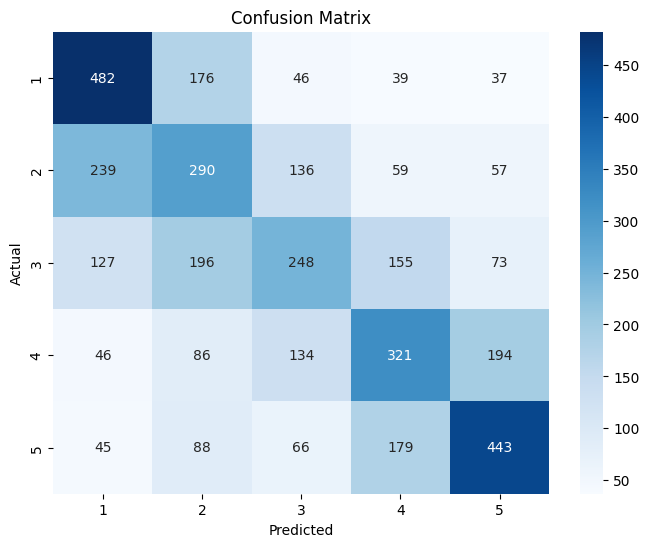

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Classification Report
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# XGBoost

In [ ]:
from xgboost import XGBClassifier

# 1. Shift labels to start from 0
y_train_adj = y_train - 1
y_test_adj = y_test - 1

# 2. Initialize XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='mlogloss'  # for multi-class classification
)

# 3. Train the model
xgb_model.fit(X_train_reduced, y_train_adj)

# 4. Predict on the test set
y_pred_adj = xgb_model.predict(X_test_reduced)

# 5. Shift predictions back to original labels
y_pred = y_pred_adj + 1


Test Accuracy: 0.4372

Classification Report:
               precision    recall  f1-score   support

           1       0.48      0.60      0.53       780
           2       0.34      0.33      0.34       781
           3       0.39      0.32      0.35       799
           4       0.41      0.41      0.41       781
           5       0.54      0.52      0.53       821

    accuracy                           0.44      3962
   macro avg       0.43      0.44      0.43      3962
weighted avg       0.43      0.44      0.43      3962



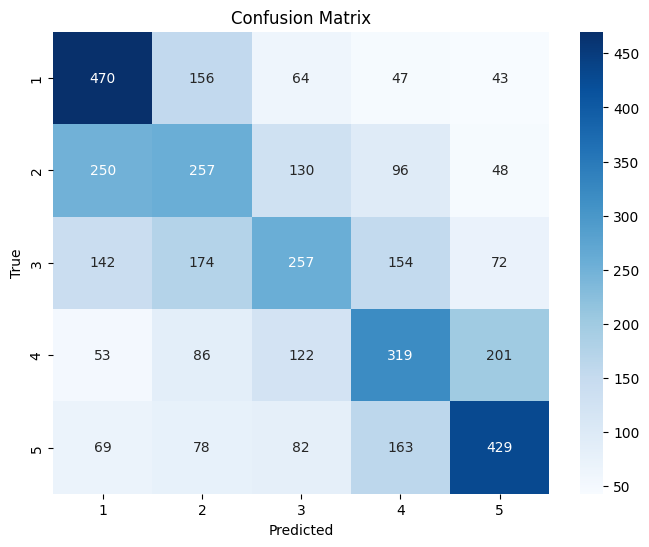

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 6. Evaluate the model
# 6.1 Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))

# 6.2 Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 6.3 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Why Use Naive Bayes, Logistic Regression, and XGBoost?

In this project, three different machine learning algorithms — **Naive Bayes (NB), Logistic Regression (LR), and XGBoost (XGB)** — were chosen to address the multiclass text classification problem. Each method brings unique strengths to the table:

**Naive Bayes (NB):** This model is particularly effective for text classification due to its simplicity and the assumption of independence between features. It works well when the relationship between features and the target variable is probabilistic, making it ideal for tasks like sentiment analysis.

**Logistic Regression (LR):** Logistic Regression is a linear classifier that is widely used in classification tasks. It can handle large feature sets, such as those from text data (e.g., TF-IDF vectors), and provides an interpretable model with probabilities for each class. It's a good baseline to compare other, more complex models.

**XGBoost (XGB):** XGBoost is an advanced gradient-boosting algorithm known for its high performance, particularly on structured data. It handles large datasets efficiently and often performs better on complex, non-linear relationships. XGBoost is well-suited for a text classification problem like this where there may be intricate interactions between the words and sentiment of the reviews.

# Evaluation of Performance

The models were evaluated using the following key metrics:

**Accuracy:** The proportion of correctly predicted instances. For XGBoost, accuracy is 43.72%, for Logistic Regression 45.03%, and for Naive Bayes 46.49%. While accuracy gives a general sense of model performance, it can be misleading in imbalanced datasets.

**Precision:** The proportion of positive predictions that are correct. High precision for a class means fewer false positives, which is crucial when false positives are costly.

**Recall:** The ability of the model to correctly identify all positive instances. High recall minimizes false negatives, ensuring that actual instances are not missed.

**F1-Score:** The harmonic mean of precision and recall, providing a balanced view of performance, especially useful in imbalanced datasets.

**Macro Average:** The average precision, recall, and F1-score across all classes, treating them equally regardless of their frequency.

**Weighted Average:** The average considering the number of instances per class, giving more weight to the performance on frequent classes, which is useful for imbalanced datasets.

#Observations

# Reflections and Future Work
In this project, I developed a text classification pipeline to predict product review ratings based on **Amazon Electronics review texts**. Through experimenting with **Naive Bayes**, **Logistic Regression**, and **XGBoost**, I learned how different models handle textual data and the impact of feature representations like TF-IDF with unigrams and bigrams, followed by dimensionality reduction using **Truncated SVD**.

Since the dataset has relatively balanced class distributions, evaluation metrics such as accuracy, precision, recall, and F1-score provide a reliable assessment of model performance. Overall, the models performed better on extreme ratings (1-star and 5-sta**r) but struggled with middle ratings (2-star, 3-star, and 4-star)**, indicating that simple TF-IDF features may not fully capture nuanced differences in review sentiment.

The strengths of the current pipeline include its simplicity, interpretability, and solid baseline performance. However, limitations include insufficient feature richness and moderate model accuracy. In future work, I plan to explore advanced text representations such as pre-trained **word embedding**s (e.g., Word2Vec, GloVe) or transformer-based embeddings. Additionally, **hyperparameter tuning**, **model ensembling**, and experimenting with **deep learning models** could further enhance classification performance.

